# Generating and Segmenting with Character-Level Transformer

In [14]:
import sys
sys.path.append('../')
import numpy as np

## Load corpus

In [15]:
from datasets import load_dataset
dataset = load_dataset('transformersegmentation/CHILDES_EnglishNA')
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset childes_english_na downloaded and prepared to /Users/zebulongoriely/.cache/huggingface/datasets/transformersegmentation___childes_english_na/full/1.0.0/fae6154891a4bae471c04c7f324ef76b5da7f8c32981606c5ceec3d1373563cf. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 898356
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 49908
    })
    test: Dataset({
        features: ['text'],
        num_rows: 49908
    })
})

## Load model

In [16]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained('transformersegmentation/Space-Tokenizer')
model = AutoModelForCausalLM.from_pretrained('transformersegmentation/GPT2-gpt2_lm_head_model-model')

In [17]:
# Generate a sample
input_ids = tokenizer.encode('h', return_tensors='pt')
sample_outputs = model.generate(input_ids, do_sample=True, max_length=50, top_k=10, top_p=0.95, num_return_sequences=3, pad_token_id=tokenizer.pad_token_id)
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))


0: h æ p i æ t h oʊ m UTT_BOUNDARY oʊ UTT_BOUNDARY h iː z ɡ ə n ə b ɹ ɪ ŋ m iː ɐ b l uː h æ n d UTT_BOUNDARY oʊ k eɪ UTT_BOUNDARY n oʊ h iː ɪ z n ɑː t s p oʊ
1: h aʊ m ɛ n i UTT_BOUNDARY w ʌ n t uː θ ɹ iː f oːɹ f aɪ v UTT_BOUNDARY n aʊ w ʌ t d uː j uː θ ɪ ŋ k ɪ t ɪ z UTT_BOUNDARY d uː j uː w ɑː n t s ʌ m
2: h uː d uː j uː l aɪ k t ə b i d uː ɪ ŋ ð æ t UTT_BOUNDARY w ʌ t s ð ɪ s w ʌ n UTT_BOUNDARY w ʌ t ɪ z ð ɪ s w ʌ n UTT_BOUNDARY h ɪɹ z ɐ k æ


## Attention Visualisation

In [18]:
import matplotlib.pyplot as plt
import seaborn

In [19]:
prompt = dataset['train']['text'][0]

def visualise_attention(prompt):
    input = tokenizer.encode(prompt, return_tensors='pt')
    prompt_text = tokenizer.convert_ids_to_tokens(input[0])
    out = model.forward(input, labels=input, output_attentions=True, output_hidden_states=True, return_dict=True)
    attentions = [att.detach().numpy() for att in out.attentions]
    
    for layer in range(1, len(attentions), 2):
        fig, axs = plt.subplots(1,8, figsize=(20, 10))
        print("Encoder Layer", layer+1)
        for h in range(8):
            seaborn.heatmap(attentions[layer][:,h][0], 
                xticklabels=prompt_text, square=True, yticklabels=prompt_text if h ==0 else [], vmin=0, vmax=1,
                cbar=False, ax=axs[h])
        plt.show()

#visualise_attention(prompt)



## Prediction Error

Plotting of prediction error from a model given a prompt.

In [20]:
def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 10))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)
        for j, start in enumerate(data.Starts):
            if start:
                ax.axvline(x=j, color='grey', alpha=0.5)
        if cutoffs:
            ax.axhline(y=cutoffs[i], color='pink', alpha=0.5)
    ax.set_xlabel('Phonemes')
    plt.show()

def print_best_result(results, score):
    best_results = results[results[score] == results[score].max()].iloc[0]
    best_result = float(best_results[score])
    best_cutoff = float(best_results['Cutoff'])
    print('Best cutoff:',best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = seaborn.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    seaborn.lineplot(results, x=measure1, y=measure2)
    plt.show()

In [21]:
from src.segmentation.segment import Segmenter
segmenter = Segmenter(model, tokenizer, dataset['train']['text'][:3000])

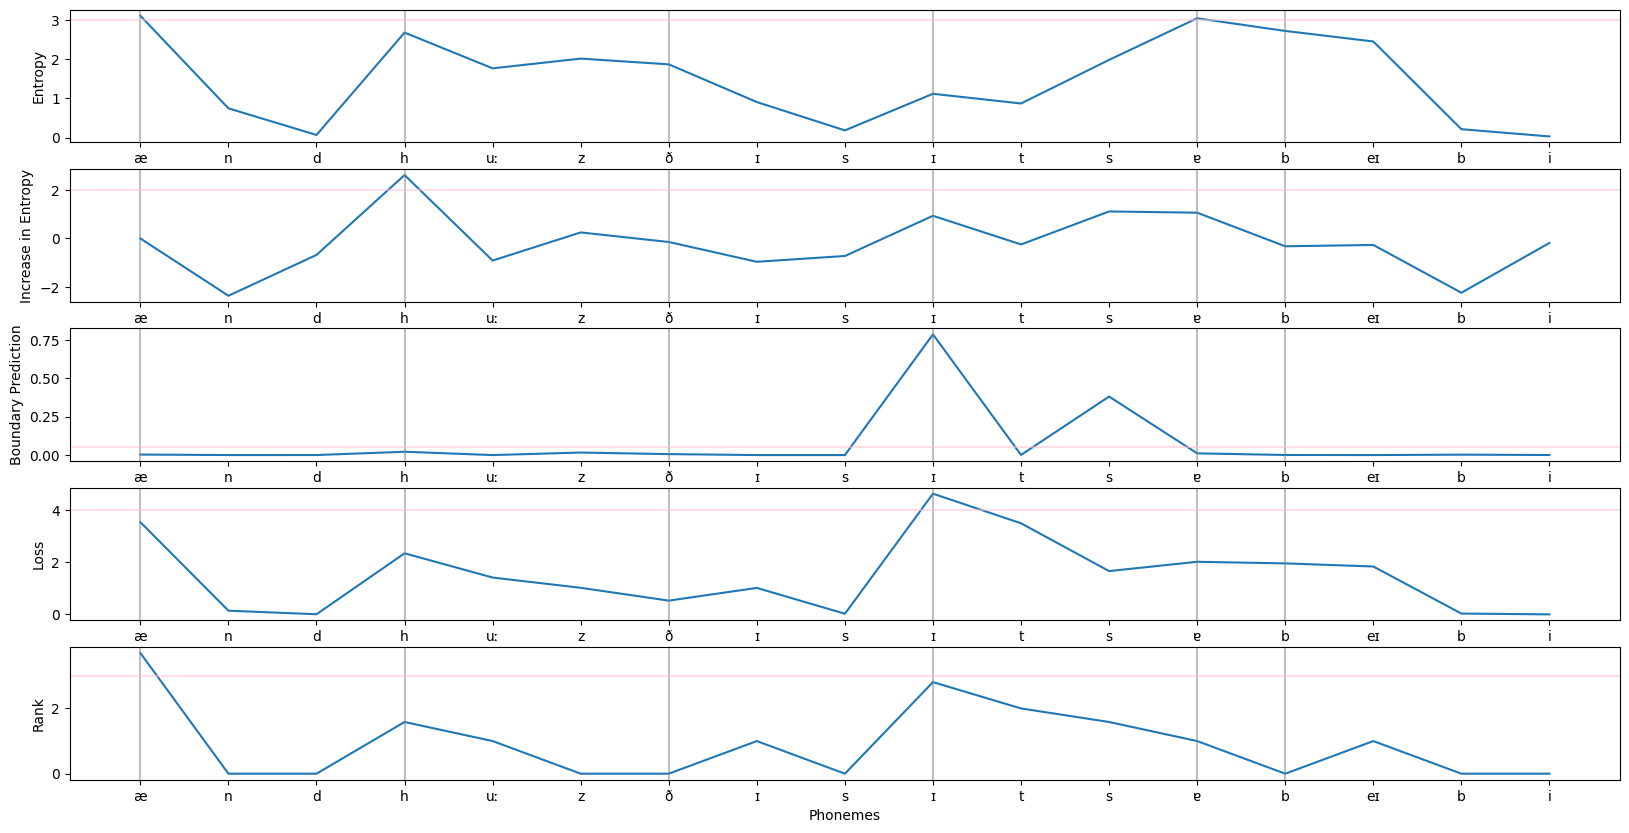

ændhuːzðɪsɪtsɐbeɪbi


In [22]:
plot_utterance(segmenter.processed_utterances[21], ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Loss', 'Rank'], [3, 2, 0.05, 4, 3])
print(''.join(list(segmenter.processed_utterances[21].Phoneme)))

In [27]:
def summarise_segmentation(measure='Entropy', score='type_fscore', cutoffs=np.linspace(0,5,51), show_plots=False):

    cutoff_data = segmenter.evaluate_cutoff_segmentation(measure, cutoffs)
    print_best_result(cutoff_data, 'type_fscore')
    if show_plots:
        plot_scores_by_cutoff(cutoff_data)
        plot_roc(cutoff_data[:-4], 'type_precision', 'type_recall')

    spike_data = segmenter.evaluate_spike_segmentation(measure)
    print('Spike {}: {}'.format(score, round(spike_data[score]*100,2)))

In [28]:
for measure in ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Increase in Boundary Prediction', 'Loss', 'Increase in Loss', 'Rank', 'Increase in Rank']:
    print(measure)
    summarise_segmentation(measure)

Entropy
Best cutoff: 1.9000000000000001
Best type_fscore at cutoff 1.9000000000000001: 34.16
Spike type_fscore: 43.99
Increase in Entropy
Best cutoff: 0.4
Best type_fscore at cutoff 0.4: 51.28
Spike type_fscore: 46.91
Boundary Prediction
Best cutoff: 0.1
Best type_fscore at cutoff 0.1: 25.17
Spike type_fscore: 43.87
Increase in Boundary Prediction
Best cutoff: 0.0
Best type_fscore at cutoff 0.0: 32.97
Spike type_fscore: 42.06
Loss
Best cutoff: 1.4000000000000001
Best type_fscore at cutoff 1.4000000000000001: 31.61
Spike type_fscore: 38.09
Increase in Loss
Best cutoff: 0.2
Best type_fscore at cutoff 0.2: 44.85
Spike type_fscore: 43.41
Rank
Best cutoff: 1.0
Best type_fscore at cutoff 1.0: 30.66
Spike type_fscore: 36.19
Increase in Rank
Best cutoff: 0.9
Best type_fscore at cutoff 0.9: 42.66
Spike type_fscore: 40.99


Best cutoff: 1.9000000000000001
Best type_fscore at cutoff 1.9000000000000001: 34.16


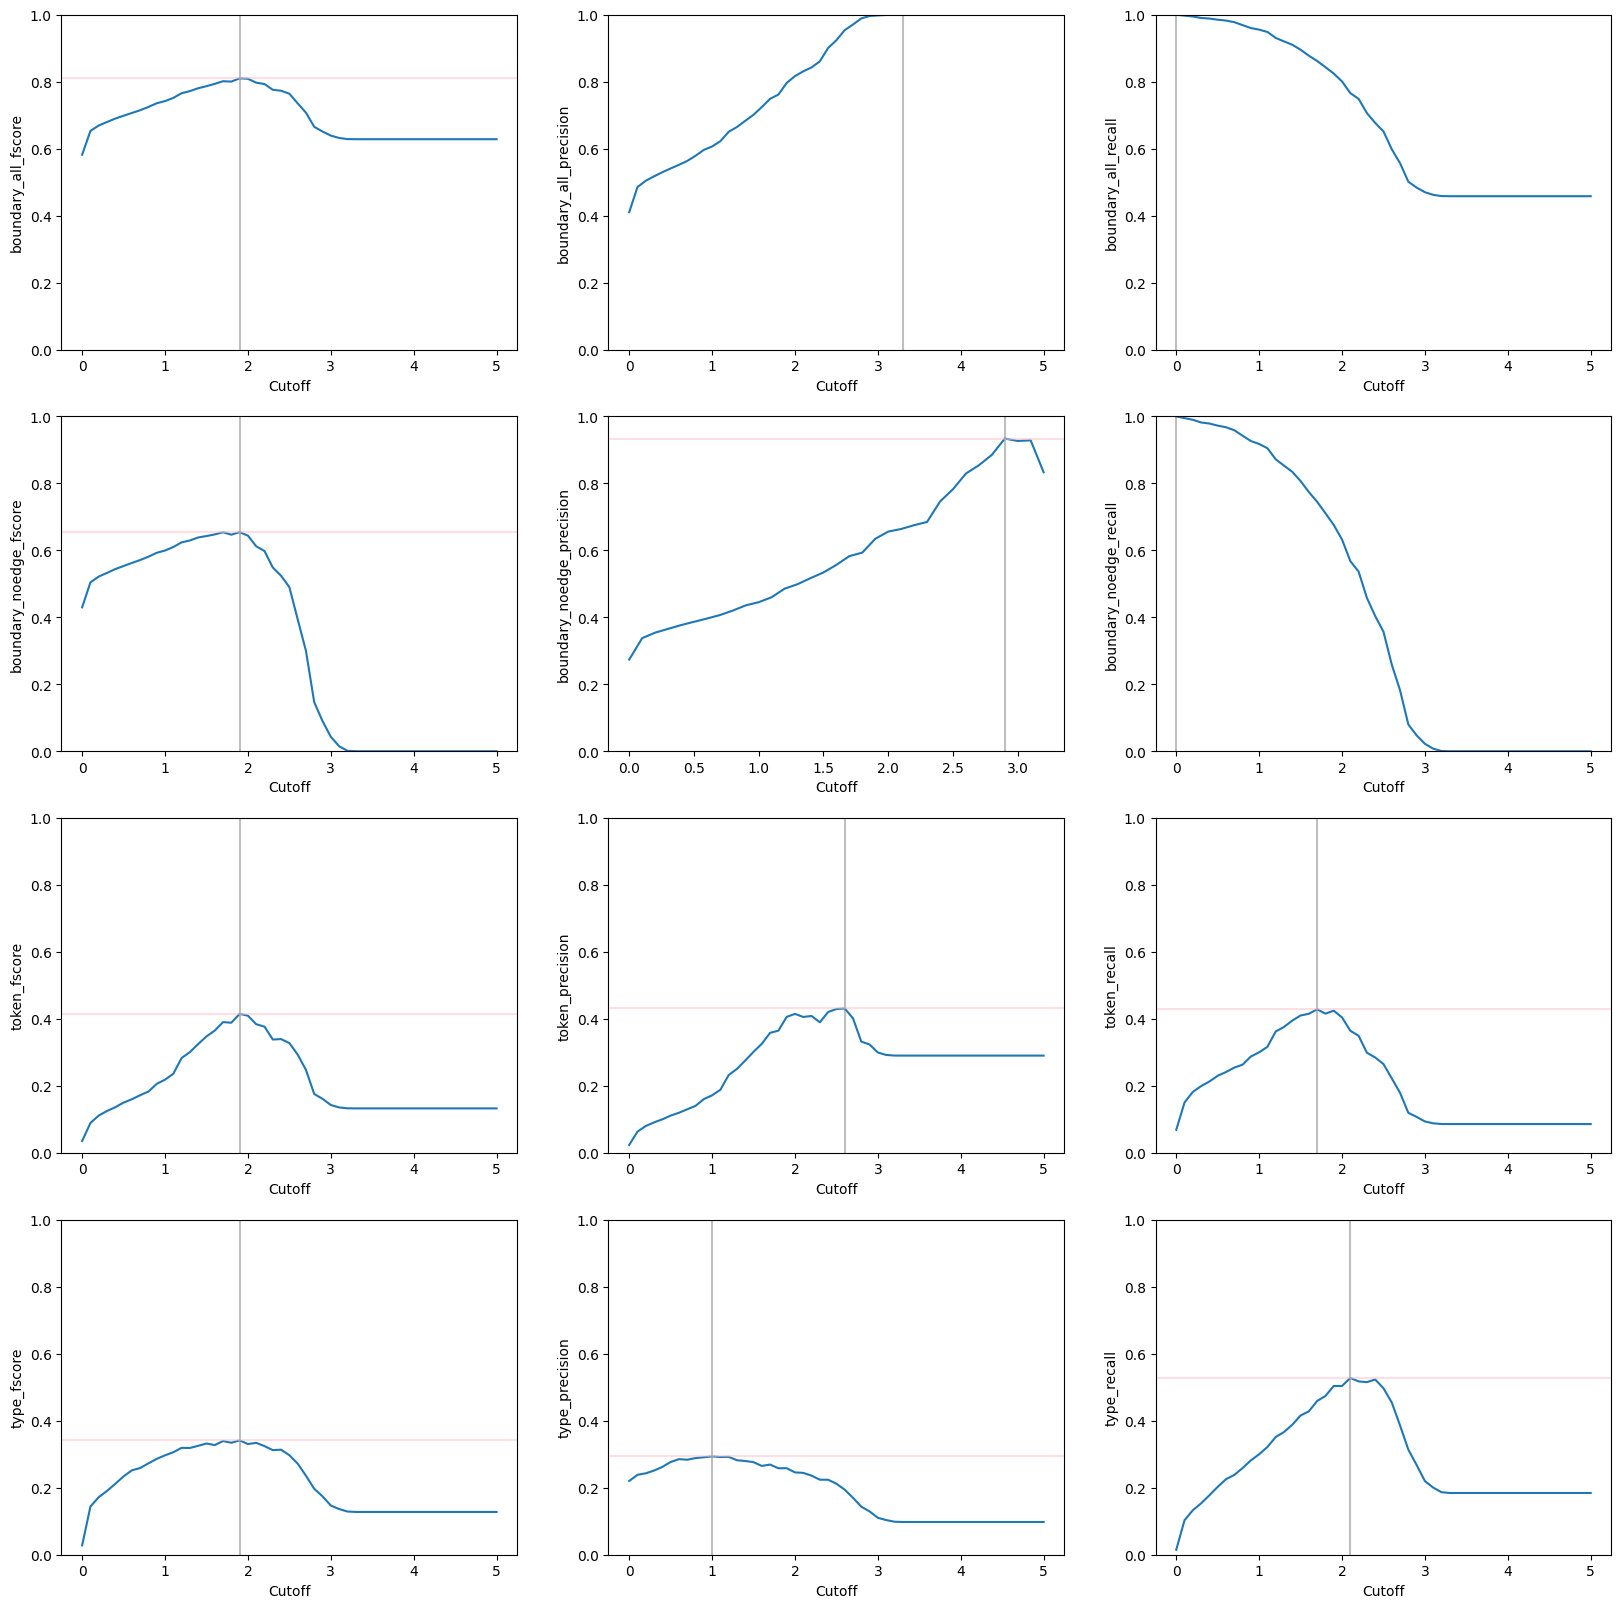

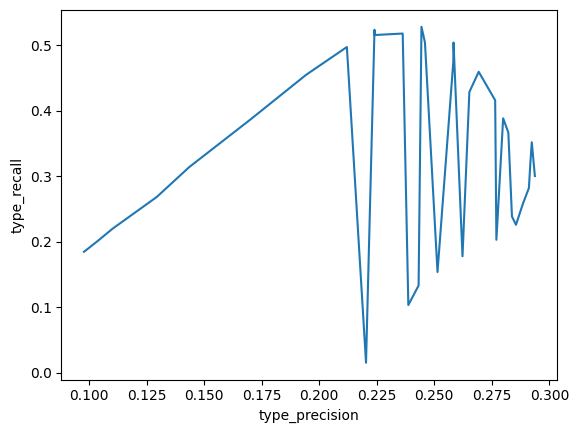

Spike type_fscore: 43.99


In [29]:
summarise_segmentation('Entropy', cutoffs=np.linspace(0,5,51), show_plots=True)